In [1]:
import pandas as pd
from datetime import timedelta
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

In [2]:
# Utility Functions
def loadActivityDataset():
    activityDataset = pd.read_csv("data/distance-activity-data.csv")
    activityDataset['point_timestamp'] = activityDataset['point_timestamp'].astype('datetime64[m]')
    activityDataset = activityDataset.rename(columns={"point_value(kilometers)":"activity_value"})
    activityDataset = activityDataset.drop(columns=['timezone_offset','device'])
    activityDataset['month'] = pd.DatetimeIndex(activityDataset['point_timestamp']).month
    activityDataset['day'] = pd.DatetimeIndex(activityDataset['point_timestamp']).day
    activityDataset['hour'] = pd.DatetimeIndex(activityDataset['point_timestamp']).hour
    activityDataset = activityDataset.reset_index(drop=True)
    return activityDataset

def loadBloodGlucoseData():
    bloodGlucoseDataset = pd.read_csv("data/blood-glucose-data.csv",parse_dates=['point_timestamp'])
    bloodGlucoseDataset['point_timestamp'] = bloodGlucoseDataset['point_timestamp'].astype('datetime64[m]')
    bloodGlucoseDataset = bloodGlucoseDataset.rename(columns={"point_value(mg/dL)":"bg_value"})
    bloodGlucoseDataset = bloodGlucoseDataset.drop(columns=['timezone_offset'])
    bloodGlucoseDataset['month'] = pd.DatetimeIndex(bloodGlucoseDataset['point_timestamp']).month
    bloodGlucoseDataset['day'] = pd.DatetimeIndex(bloodGlucoseDataset['point_timestamp']).day
    bloodGlucoseDataset['hour'] = pd.DatetimeIndex(bloodGlucoseDataset['point_timestamp']).hour
    bloodGlucoseDataset = bloodGlucoseDataset.reset_index(drop=True)
    return bloodGlucoseDataset

def loadHeartData():
    heartDataset = pd.read_csv("data/heart-rate-data.csv",parse_dates=['point_timestamp'])
    heartDataset = heartDataset.drop(columns=['timezone_offset'])  
    heartDataset = heartDataset.rename(columns={"point_value":"beat_value"})
    heartDataset['month'] = pd.DatetimeIndex(heartDataset['point_timestamp']).month
    heartDataset['day'] = pd.DatetimeIndex(heartDataset['point_timestamp']).day
    heartDataset['hour'] = pd.DatetimeIndex(heartDataset['point_timestamp']).hour
    heartDataset = heartDataset.reset_index(drop=True)
    return heartDataset

In [3]:
# Using Clarke Error Grid Function from Github Repo : https://github.com/suetAndTie/ClarkeErrorGrid/blob/master/ClarkeErrorGrid.py
'''
CLARKE ERROR GRID ANALYSIS      ClarkeErrorGrid.py
Need Matplotlib Pyplot
The Clarke Error Grid shows the differences between a blood glucose predictive measurement and a reference measurement,
and it shows the clinical significance of the differences between these values.
The x-axis corresponds to the reference value and the y-axis corresponds to the prediction.
The diagonal line shows the prediction value is the exact same as the reference value.
This grid is split into five zones. Zone A is defined as clinical accuracy while
zones C, D, and E are considered clinical error.
Zone A: Clinically Accurate
    This zone holds the values that differ from the reference values no more than 20 percent
    or the values in the hypoglycemic range (<70 mg/dl).
    According to the literature, values in zone A are considered clinically accurate.
    These values would lead to clinically correct treatment decisions.
Zone B: Clinically Acceptable
    This zone holds values that differe more than 20 percent but would lead to
    benign or no treatment based on assumptions.
Zone C: Overcorrecting
    This zone leads to overcorrecting acceptable BG levels.
Zone D: Failure to Detect
    This zone leads to failure to detect and treat errors in BG levels.
    The actual BG levels are outside of the acceptable levels while the predictions
    lie within the acceptable range
Zone E: Erroneous treatment
    This zone leads to erroneous treatment because prediction values are opposite to
    actual BG levels, and treatment would be opposite to what is recommended.
SYNTAX:
        plot, zone = clarke_error_grid(ref_values, pred_values, title_string)
INPUT:
        ref_values          List of n reference values.
        pred_values         List of n prediciton values.
        title_string        String of the title.
OUTPUT:
        plot                The Clarke Error Grid Plot returned by the function.
                            Use this with plot.show()
        zone                List of values in each zone.
                            0=A, 1=B, 2=C, 3=D, 4=E
EXAMPLE:
        plot, zone = clarke_error_grid(ref_values, pred_values, "00897741 Linear Regression")
        plot.show()
References:
[1]     Clarke, WL. (2005). "The Original Clarke Error Grid Analysis (EGA)."
        Diabetes Technology and Therapeutics 7(5), pp. 776-779.
[2]     Maran, A. et al. (2002). "Continuous Subcutaneous Glucose Monitoring in Diabetic
        Patients" Diabetes Care, 25(2).
[3]     Kovatchev, B.P. et al. (2004). "Evaluating the Accuracy of Continuous Glucose-
        Monitoring Sensors" Diabetes Care, 27(8).
[4]     Guevara, E. and Gonzalez, F. J. (2008). Prediction of Glucose Concentration by
        Impedance Phase Measurements, in MEDICAL PHYSICS: Tenth Mexican
        Symposium on Medical Physics, Mexico City, Mexico, vol. 1032, pp.
        259261.
[5]     Guevara, E. and Gonzalez, F. J. (2010). Joint optical-electrical technique for
        noninvasive glucose monitoring, REVISTA MEXICANA DE FISICA, vol. 56,
        no. 5, pp. 430434.
Made by:
Trevor Tsue
7/18/17
Based on the Matlab Clarke Error Grid Analysis File Version 1.2 by:
Edgar Guevara Codina
codina@REMOVETHIScactus.iico.uaslp.mx
March 29 2013
'''

#This function takes in the reference values and the prediction values as lists and returns a list with each index corresponding to the total number
#of points within that zone (0=A, 1=B, 2=C, 3=D, 4=E) and the plot
def clarke_error_grid(ref_values, pred_values, title_string):
    
    #Checking to see if the lengths of the reference and prediction arrays are the same
    assert (len(ref_values) == len(pred_values)), "Unequal number of values (reference : {}) (prediction : {}).".format(len(ref_values), len(pred_values))

    #Checks to see if the values are within the normal physiological range, otherwise it gives a warning
    if max(ref_values) > 400 or max(pred_values) > 400:
        print("Input Warning: the maximum reference value {} or the maximum prediction value {} exceeds the normal physiological range of glucose (<400 mg/dl).".format(max(ref_values), max(pred_values)))
    if min(ref_values) < 0 or min(pred_values) < 0:
        print("Input Warning: the minimum reference value {} or the minimum prediction value {} is less than 0 mg/dl.".format(min(ref_values),  min(pred_values)))

    #Clear plot
    plt.clf()

    #Set up plot
    plt.scatter(ref_values, pred_values, marker='o', color='black', s=8)
    plt.title(title_string + " Clarke Error Grid")
    plt.xlabel("Reference Concentration (mg/dl)")
    plt.ylabel("Prediction Concentration (mg/dl)")
    plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.yticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.gca().set_facecolor('white')

    #Set axes lengths
    plt.gca().set_xlim([0, 400])
    plt.gca().set_ylim([0, 400])
    plt.gca().set_aspect((400)/(400))

    #Plot zone lines
    plt.plot([0,400], [0,400], ':', c='black')                      #Theoretical 45 regression line
    plt.plot([0, 175/3], [70, 70], '-', c='black')
    #plt.plot([175/3, 320], [70, 400], '-', c='black')
    plt.plot([175/3, 400/1.2], [70, 400], '-', c='black')           #Replace 320 with 400/1.2 because 100*(400 - 400/1.2)/(400/1.2) =  20% error
    plt.plot([70, 70], [84, 400],'-', c='black')
    plt.plot([0, 70], [180, 180], '-', c='black')
    plt.plot([70, 290],[180, 400],'-', c='black')
    # plt.plot([70, 70], [0, 175/3], '-', c='black')
    plt.plot([70, 70], [0, 56], '-', c='black')                     #Replace 175.3 with 56 because 100*abs(56-70)/70) = 20% error
    # plt.plot([70, 400],[175/3, 320],'-', c='black')
    plt.plot([70, 400], [56, 320],'-', c='black')
    plt.plot([180, 180], [0, 70], '-', c='black')
    plt.plot([180, 400], [70, 70], '-', c='black')
    plt.plot([240, 240], [70, 180],'-', c='black')
    plt.plot([240, 400], [180, 180], '-', c='black')
    plt.plot([130, 180], [0, 70], '-', c='black')

    #Add zone titles
    plt.text(30, 15, "A", fontsize=15)
    plt.text(370, 260, "B", fontsize=15)
    plt.text(280, 370, "B", fontsize=15)
    plt.text(160, 370, "C", fontsize=15)
    plt.text(160, 15, "C", fontsize=15)
    plt.text(30, 140, "D", fontsize=15)
    plt.text(370, 120, "D", fontsize=15)
    plt.text(30, 370, "E", fontsize=15)
    plt.text(370, 15, "E", fontsize=15)

    #Statistics from the data
    zone = [0] * 5
    for i in range(len(ref_values)):
        if (ref_values[i] <= 70 and pred_values[i] <= 70) or (pred_values[i] <= 1.2*ref_values[i] and pred_values[i] >= 0.8*ref_values[i]):
            zone[0] += 1    #Zone A

        elif (ref_values[i] >= 180 and pred_values[i] <= 70) or (ref_values[i] <= 70 and pred_values[i] >= 180):
            zone[4] += 1    #Zone E

        elif ((ref_values[i] >= 70 and ref_values[i] <= 290) and pred_values[i] >= ref_values[i] + 110) or ((ref_values[i] >= 130 and ref_values[i] <= 180) and (pred_values[i] <= (7/5)*ref_values[i] - 182)):
            zone[2] += 1    #Zone C
        elif (ref_values[i] >= 240 and (pred_values[i] >= 70 and pred_values[i] <= 180)) or (ref_values[i] <= 175/3 and pred_values[i] <= 180 and pred_values[i] >= 70) or ((ref_values[i] >= 175/3 and ref_values[i] <= 70) and pred_values[i] >= (6/5)*ref_values[i]):
            zone[3] += 1    #Zone D
        else:
            zone[1] += 1    #Zone B
    print(f"% of Samples in ZoneA : {(zone[0])/(zone[0]+zone[1]+zone[2]+zone[3]+zone[4])}")
    print(f"% of Samples in ZoneB : {(zone[1])/(zone[0]+zone[1]+zone[2]+zone[3]+zone[4])}")
    print(f"% of Samples in ZoneC : {(zone[2])/(zone[0]+zone[1]+zone[2]+zone[3]+zone[4])}")
    print(f"% of Samples in ZoneD : {(zone[3])/(zone[0]+zone[1]+zone[2]+zone[3]+zone[4])}")
    print(f"% of Samples in ZoneE : {(zone[4])/(zone[0]+zone[1]+zone[2]+zone[3]+zone[4])}")
    #return plt, zone

In [4]:
bloodGlucoseDataset = loadBloodGlucoseData()
activityDataset = loadActivityDataset()
heartDataset = loadHeartData()

In [5]:
bloodGlucoseDataset.head()

,bg_value,point_timestamp,month,day,hour
0,142,2017-05-15 07:51:00,5,15,7
1,140,2017-05-15 07:56:00,5,15,7
2,138,2017-05-15 08:01:00,5,15,8
3,136,2017-05-15 08:06:00,5,15,8
4,130,2017-05-15 08:11:00,5,15,8


In [6]:
activityDataset.head()

,activity_value,point_timestamp,month,day,hour
0,0.03607,2017-05-15 15:52:00,5,15,15
1,0.30443,2017-05-15 15:59:00,5,15,15
2,0.31764,2017-05-15 16:09:00,5,15,16
3,0.16387,2017-05-15 16:16:00,5,15,16
4,0.01675,2017-05-15 16:27:00,5,15,16


In [7]:
heartDataset.head()

,beat_value,point_timestamp,month,day,hour
0,98,2017-05-16 22:16:00,5,16,22
1,104,2017-05-16 22:17:00,5,16,22
2,110,2017-05-16 22:18:00,5,16,22
3,112,2017-05-16 22:19:00,5,16,22
4,97,2017-05-16 22:20:00,5,16,22


<h2>Analyzing activity and blood glucose trends together</h2>

In [8]:
mergedDataset = pd.merge(bloodGlucoseDataset,activityDataset,how="left",on='point_timestamp')
mergedDataset = mergedDataset.dropna()
mergedDataset = mergedDataset.reset_index(drop=True)

In [9]:
#Looking at correlation between activity and blood glucose
mergedDataset[['bg_value','activity_value']].corr()

,bg_value,activity_value
bg_value,1.000000,-0.028998
activity_value,-0.028998,1.000000


In [10]:
# Looking at subset of data for correlation
mergedDataset.loc[100:200,['bg_value','activity_value']].corr()

,bg_value,activity_value
bg_value,1.0,NaN
activity_value,NaN,NaN


In [11]:
# Nan suggests 0 values
mergedDataset[mergedDataset['activity_value']<=0].shape[0]/mergedDataset.shape[0]

0.9351410273879275

In [12]:
#93% of values in merged dataset are zero

In [13]:
activityDataset[activityDataset['activity_value']<=0].shape[0]/activityDataset.shape[0]

0.9404145077720207

In [14]:
#94% of values in activity dataset are zero. Which makes sense because normal person spends only some part to his time in activities.
#And that is the reason for low correlation value

In [15]:
#Lets analyse the blood Glucose data along with activity data for a day

In [16]:
#Plotting activity and blood glucose data for a day on 2 different graphs. Plotting them on different graphs for simplicity in visualization.
def plotDataForDay(month,day):
    subset1 = bloodGlucoseDataset[(bloodGlucoseDataset.month==month) & (bloodGlucoseDataset.day==day)]
    subset2 = activityDataset[(activityDataset.month==month) & (activityDataset.day==day)]
    mergedData = pd.merge(subset1,subset2,how="outer",on="point_timestamp")
    mergedData = mergedData.fillna(0)
    print(f"Corellation Value between blood Glucose and activity is {mergedData[['bg_value','activity_value']].corr().iloc[0,1]}")
    ax = mergedData[['bg_value','point_timestamp']].plot(x='point_timestamp',figsize=(15,5),title="Blood Glucose Variation across a day")
    mergedData[['activity_value','point_timestamp']].plot(x='point_timestamp',figsize=(15,5),title="Activity Variation across a day")

Corellation Value between blood Glucose and activity is -0.23470577685843166


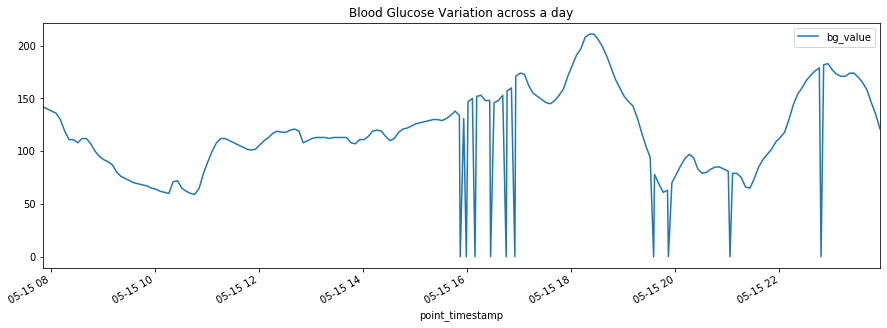

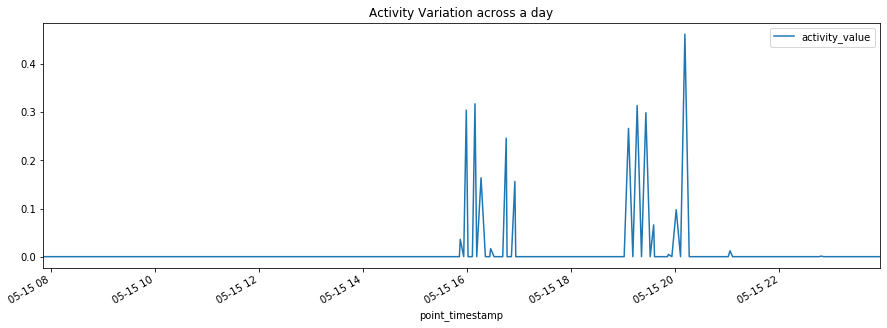

In [17]:
plotDataForDay(5,15)

Corellation Value between blood Glucose and activity is -0.005917226095725489


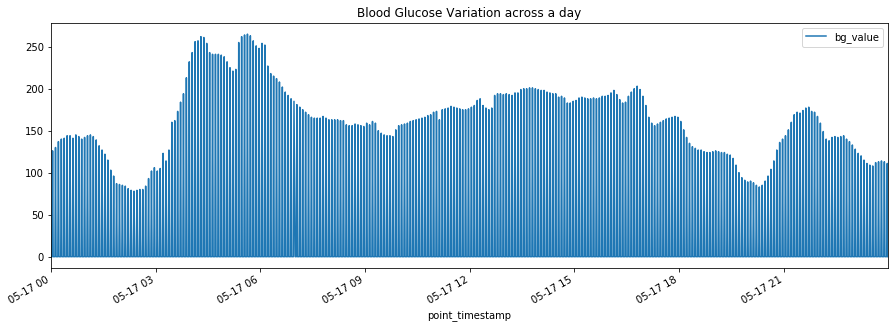

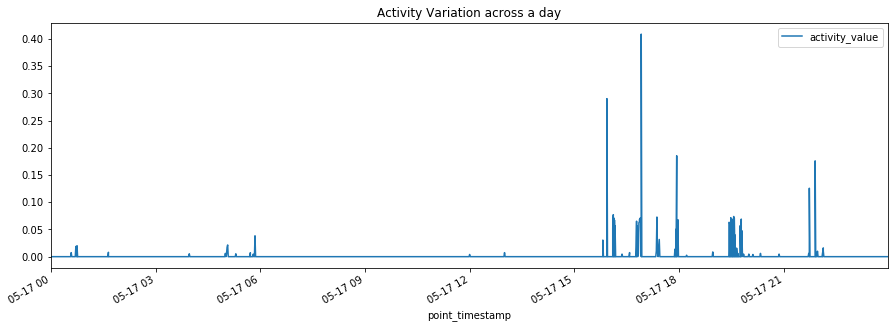

In [18]:
plotDataForDay(5,17)

Corellation Value between blood Glucose and activity is -0.02685928841090789


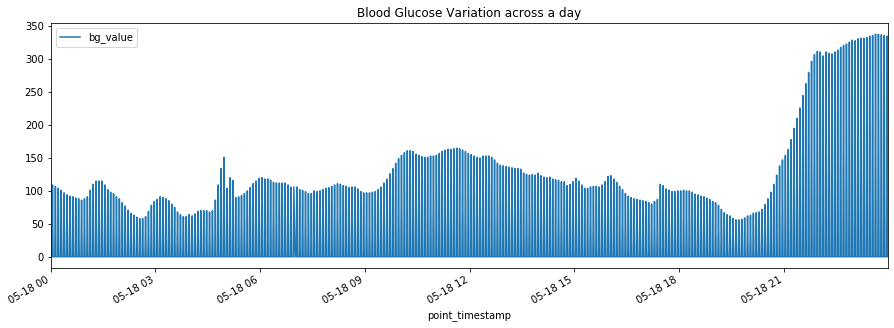

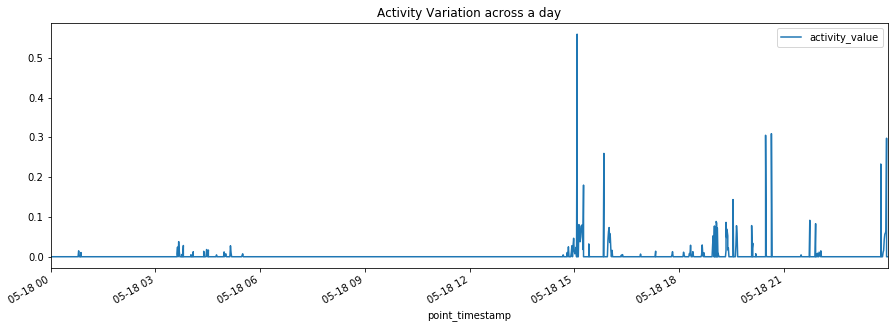

In [19]:
plotDataForDay(5,18)

In [20]:
#Inference : Looking at the corellation values it seems that blood glucose and activity are not correlated. There may be a timelagged corellation.
# Since I am replacing missing values with zero. Maybe that's the reason for low correlation. Need to investigate on this further.
# Looking at the above figures it seems that activities does affect blood glucose(but in a lagged fashion) and not in all cases. 
# There could be other factors as well like time when person had food
# Hence, Will use activity data for last 4 hrs and also hour of the day as feature

<h2>Analyzing heart rate and blood glucose trends together</h2>

In [21]:
#Plotting heart rate and blood glucose data for a day on 2 different graphs. Plotting them on different graphs for simplicity in visualization.
def plotHeartWithGlucoseForDay(month,day):
    subset1 = bloodGlucoseDataset[(bloodGlucoseDataset.month==month) & (bloodGlucoseDataset.day==day)]
    subset2 = heartDataset[(heartDataset.month==month) & (heartDataset.day==day)]
    xx = pd.merge(subset1,subset2,how="outer",on="point_timestamp")
    xx = xx.fillna(0)
    print(f"Corellation Value between blood Glucose and heart rate is {xx[['bg_value','beat_value']].corr().iloc[0,1]}")
    ax = xx[['bg_value','point_timestamp']].plot(x='point_timestamp',figsize=(15,5))
    xx[['beat_value','point_timestamp']].plot(x='point_timestamp',figsize=(15,5))

Corellation Value between blood Glucose and heart rate is -0.14639202696616507


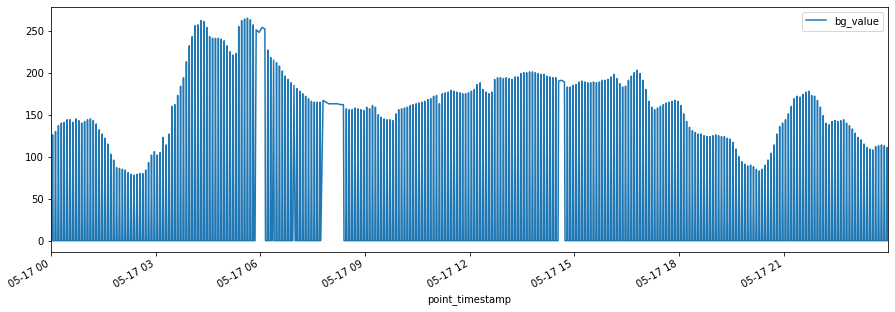

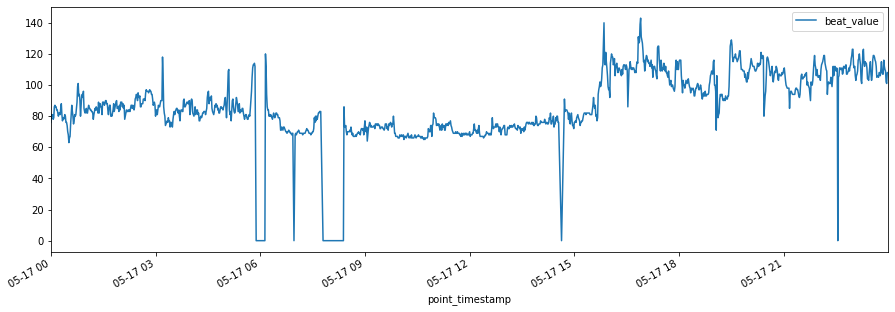

In [22]:
plotHeartWithGlucoseForDay(5,17)

Corellation Value between blood Glucose and heart rate is -0.06875177182888041


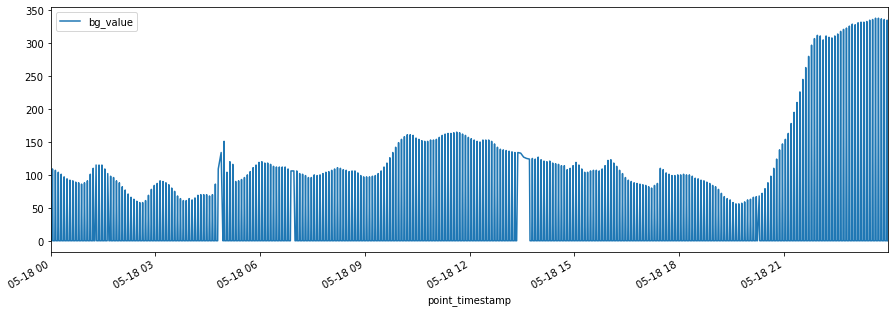

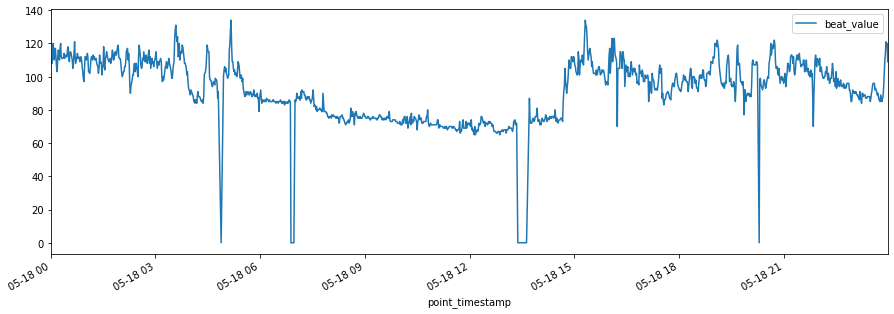

In [23]:
plotHeartWithGlucoseForDay(5,18)

In [24]:
# Inference : Same inference as above on the correlation part. Maybe need to come up with new metric to compare 
# two timeseries with missing values.
# Looking at the above figures it seems that as the heart rate increases the blood sugar goes down.

<h2> Creating Random Forest ML Model </h2>

In [25]:
# Features : 
# Blood Glucose Values : Mean of last 2,5,10,15 samples
# Heart Rates Values : Mean of last 2,5,10,15,20 samples
# Hour of the day

# Label: 12 Values of Blood Glucose for next hour(at an interval of 5 minutes)

In [26]:
# Generating features
bloodGlucoseDataset['last2ValueMean_glu'] = bloodGlucoseDataset['bg_value'].rolling(2,win_type="triang").mean()
bloodGlucoseDataset['last5ValueMean_glu'] = bloodGlucoseDataset['bg_value'].rolling(5,win_type="triang").mean()
bloodGlucoseDataset['last10ValueMean_glu'] = bloodGlucoseDataset['bg_value'].rolling(10,win_type="triang").mean()
bloodGlucoseDataset['last15ValueMean_glu'] = bloodGlucoseDataset['bg_value'].rolling(15,win_type="triang").mean()
bloodGlucoseDataset = bloodGlucoseDataset[bloodGlucoseDataset.point_timestamp>heartDataset.point_timestamp[0]]
bloodGlucoseDataset = bloodGlucoseDataset.dropna()

heartDataset['last2ValueMean_beat'] = heartDataset['beat_value'].rolling(2,win_type="triang").mean()
heartDataset['last5ValueMean_beat'] = heartDataset['beat_value'].rolling(5,win_type="triang").mean()
heartDataset['last10ValueMean_beat'] = heartDataset['beat_value'].rolling(10,win_type="triang").mean()
heartDataset['last15ValueMean_beat'] = heartDataset['beat_value'].rolling(15,win_type="triang").mean()
heartDataset['last20ValueMean_beat'] = heartDataset['beat_value'].rolling(20,win_type="triang").mean()
heartDataset = heartDataset.dropna()

In [27]:
# Generating next 12 labels
gluAndBeatMergedDataset = bloodGlucoseDataset
for i in range(12):
    gluAndBeatMergedDataset["nextBGval" + str(i)] = np.nan

for index,rows in gluAndBeatMergedDataset.iterrows():
    if(index+12 < gluAndBeatMergedDataset.shape[0]):
        for i in range(12):
            gluAndBeatMergedDataset.loc[index,"nextBGval" + str(i)] = gluAndBeatMergedDataset.loc[index+i+1,'bg_value']

# Merging Glucose and Heart beat dataset
gluAndBeatMergedDataset = pd.merge(gluAndBeatMergedDataset,heartDataset,how="left",on="point_timestamp")
gluAndBeatMergedDataset = gluAndBeatMergedDataset.dropna()


datasetX = gluAndBeatMergedDataset[['last2ValueMean_glu','last5ValueMean_glu','last10ValueMean_glu','last15ValueMean_glu','last2ValueMean_beat','last5ValueMean_beat'
                                ,'last10ValueMean_beat','last15ValueMean_beat','last20ValueMean_beat','hour_x']]
datasetY = gluAndBeatMergedDataset[['nextBGval0','nextBGval1','nextBGval2','nextBGval3','nextBGval4','nextBGval5','nextBGval6',
                                    'nextBGval7','nextBGval8','nextBGval9','nextBGval10','nextBGval11']]


In [28]:
trainX,testX,trainY,testY = train_test_split(datasetX,datasetY,test_size=0.4,shuffle=False)

In [29]:
regr = RandomForestRegressor(random_state=0,n_estimators=100)
regr.fit(trainX,trainY)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [30]:
predY = regr.predict(testX)

In [31]:
print(f"R-squared Value: {regr.score(testX,testY)}")

R-squared Value: 0.8400492032615824


D:\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [32]:
regr.feature_importances_

array([0.85471109, 0.01550385, 0.02210408, 0.03467217, 0.00886372,
       0.00946964, 0.00881868, 0.00936526, 0.01453625, 0.02195527])

Input Warning: the maximum reference value [401.] or the maximum prediction value [401.] exceeds the normal physiological range of glucose (<400 mg/dl).
% of Samples in ZoneA : 0.7897887323943662
% of Samples in ZoneB : 0.1595908786049631
% of Samples in ZoneC : 0.0015425888665325286
% of Samples in ZoneD : 0.0488430583501006
% of Samples in ZoneE : 0.00023474178403755868


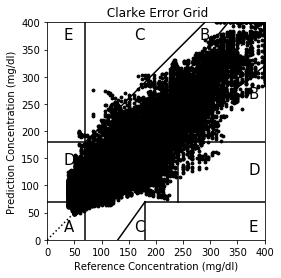

In [33]:
clarke_error_grid(testY.values.reshape(-1,1),predY.reshape(-1,1),"")